# Relocation Services
## (Battle of the Neighborhoods)
## 07/15/2020
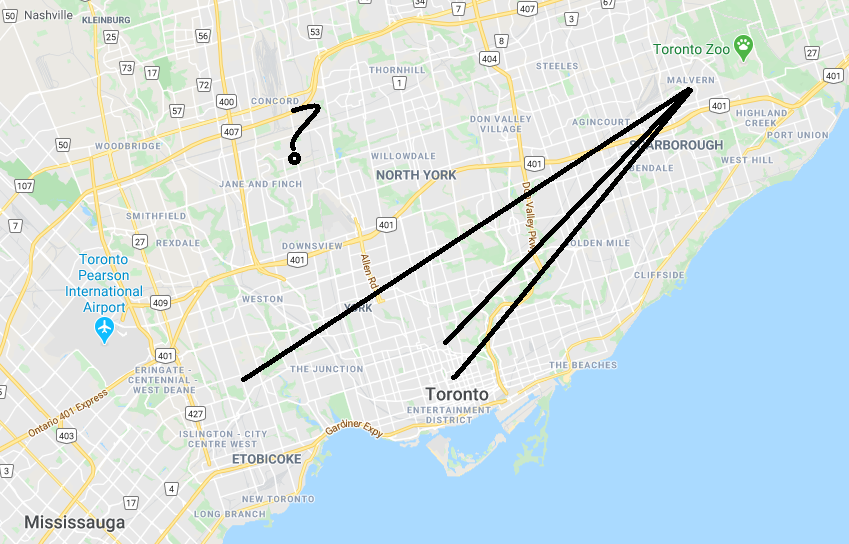

# 1. Introduction
## 1.1 Background
### We all moved atleast once in our life time. Remeber the experience...
### Anyhow, indeed, moving or relocation is a challenging task for anybody
### Their neighborhood gets changed totally but people like to have consistency in their life styles
### Need to make the adoptation to the new surroundings as smooth as possible
### Pick an educated neighborhood rather than a random neighborhood

### One way to navigate this stressful event is  to identify neighborhoods similar to those in their existing neighborhood
# This is where geolocation exploration comes in handy!

## 1.2 Problem
> 
## The Daunting task of locating one's next neighborhood
### People need to relocate to a new place or a neighborhood 
### Whether it is due to  
> 
#### a change in their job  
> 
#### a change in their financial situation
> 
#### a personal reason
> 
#### an impending retirement

> 
### The relocation creates a problem in people's life-styles, impacting their enjoyment of life
> 
### Clients need options to relocate with minimal impact to their day-to-day lives
> 
# This is where Relocation Services come to rescue!

## 1.3 Target Audience
> 
### Any relocation service providers
> 
### Clients perceive the service as a big relief in locating a suitable neighborhood 
> 
### Will have a large client base comprising of 
> 
### a) Employers with relocating employees
> 
### b) Individuals who are moving to new areas

# 2. Data 
## 2.1 Sources
### 2.1.1 Needed from the relocating person
> 
#### 1) Current location
> 
#### 2) Target location
> 
#### 3) Another important non-venue care about attribute
> Say distance from their target which can be computed using the geo location
<br>
<br>
> It could be anything else that is related to a neighborhood

### 2.1.2 Web Data
> 
#### Locale Details 
> Due to a steep cost of acquiring geo info of neighborhoods, the current project will be limited to the neighborhoods in The City of Toronto, Ontario, Canada
<br>
<br>
> Obtained local postal codes covering boroughs and neighborhoods from Wikipedia's __[Toronto's Postal Codes Link]( https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)__
#### Geolocation Data
> Used the provided geo location data from __[Google](https://www.google.com)__ 
#### Venues Data
> __[FourSquare](https://www.foursquare.com)__ venue data collected using its APIs

In [1]:
import numpy as np # For mult-dimensional arrays usage

import pandas as pd # For DataFrames usage

import requests # Enough for handling web requests with REST APIs
import urllib.request # Needed for free https sites including WikiPedia
from urllib.request import urlopen # Needed for free https sites including WikiPedia

import json #For handling json file
from pandas.io.json import json_normalize # to transform json into pd.DataFrame

from bs4 import BeautifulSoup # for processing html docs

import geocoder # for getting the geolocation information from a post code
from geopy.geocoders import Nominatim # for getting the geolocation from an address
from geopy.distance import geodesic # for distance calculations

import matplotlib.cm as cm # for color maps
import matplotlib.colors as colors # for converting numbers and color arguments to RGB and RGBA schemes

from sklearn.cluster import KMeans # for clustering KMeans module

import matplotlib.pyplot as plt 

# Ensured FourSquare APIs are available

import folium # for maps

#Miscellaneous modules
import re
from __future__ import print_function # For %% magic capture command
import sys

print("Importing all necessary modules/libraries completed.")

Importing all necessary modules/libraries completed.


Let's remove any limitations that hinder our interactive work just in case

In [2]:
pd.set_option('display.max_columns', None) # Removing display limitattion on columns
pd.set_option('display.max_rows', None) # Removing display limitattion on rows

Let's start gathering the Toronto neighborhoods by scraping the Wekipedia's web link https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

In [4]:
#initializing the columns
columns = []

#Let's gather the table data in the order of post code, burough, and grouped neighborhoods
for tag in soup.find_all('th'): # Looping through the table column headers
    if (tag.string): # To avoid Null tag.srings
        columns.append(tag.string.rstrip())

pc_hood = {} # There can be more than one neighborhoold in a post code
pc_brh = {} # The burough associated with the post code
i = 0 # initializing to keep track of the table rows with data
for tag in soup.find_all('td'): # Looping through the table data
    i_mod = i % 3
    if i_mod == 0:
        post_code = tag.string
    elif i_mod == 1:
        brh = tag.string
    elif i_mod == 2:
        if post_code and (brh.rstrip().upper() != 'NOT ASSIGNED'): # ignoring entries with a borough "Not Assigned"
            brh=brh.rstrip()
            nbrhood = tag.string.rstrip()
            post_code = post_code.rstrip()
            if nbrhood.upper() == 'NOT ASSIGNED': nbrhood = brh
            if post_code in pc_hood.keys():
                pc_hood[post_code] = pc_hood[post_code]+", " + nbrhood
            else: pc_hood[post_code] = nbrhood
            if post_code not in pc_brh.keys():
                pc_brh[post_code] = brh
            else: # Checking to see if a post code ends up in two different buroughs
                print("ERROR: post code {} is already associated with {} burough".format(post_code, pc_brh[post_code]))
                print("       post code {} is now being associated with {} burough".format(post_code, brh))
    i += 1 # preparing to index the next table entry
    
if (i % 3 != 0): #Error checking for conistency of processing 3 columns per row in table
    print("The table columns is not a multiple of 3")
    print("{}".format(i))

pc_lists =[] # Initializing the list
#for key in sorted(pc_brh.keys()): # Populating the list with processed table rows in the post code order for debug
for key in pc_brh.keys(): # Populating the list with processed table rows in the keys order
    pc_lists.append([key, pc_brh[key], pc_hood[key]])

T_DF=pd.DataFrame(pc_lists, columns=columns) # Initializing the dataframe

## 2.2 Data Pre-processing/Cleaning/Wrangling

In [5]:
# Let's examine the Postal Code DF
T_DF.head()

,Postal Code,Borough,Neighborhood
0,M6E,York,Caledonia-Fairbanks
1,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
2,M5C,Downtown Toronto,St. James Town
3,M2N,North York,"Willowdale, Willowdale East"
4,M2J,North York,"Fairview, Henry Farm, Oriole"


In [6]:
# Let's check the size of the DF
T_DF.shape

(103, 3)

In [7]:
# Multiple triesdid not work with Google at different times on different days
# hence let's use the provided csv data.
pc_lat_lng = pd.read_csv("C:\\Users\\krish\\DataScience\\projects\\capstone\\Geospatial_Coordinates.csv", header=0)
pc_lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
#  Let's check the size
pc_lat_lng.shape

(103, 3)

In [9]:
# Merging pc_lat_lng with DF_T on 'Postal Code' key column
# In pc_lat_lng, need to make the 'Postal Code' column as its index for merging with the column of DF_T
T_DF=T_DF.join(pc_lat_lng.set_index('Postal Code'), on='Postal Code')
T_DF

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
1,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493
4,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
5,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
6,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049
7,M9N,York,Weston,43.706876,-79.518188
8,M4A,North York,Victoria Village,43.725882,-79.315572
9,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763


In [10]:
%%capture crnt_trgt_interaction

def get_postal_code(type):
    complete = False
    while not complete:
        
        hood=input("Your " + type + " postal code with 3 chars starting with M, a digit, and a char: ")
        hood = hood.upper()
        if any(T_DF['Postal Code'].isin([hood])):
            print ("Your entered {} postal code: {}".format(type, hood))
            complete = True
        else: 
            print ("Your entered {} postal code: {} is not valid.".format(type, hood))
            print ("Let's try again.")
    return hood
# Let's get client's needs

crnt_hood=get_postal_code("current") # getting current postal code
trgt_hood=get_postal_code("target") # getting target postal code

Your current postal code with 3 chars starting with M, a digit, and a char: m1g
Your target postal code with 3 chars starting with M, a digit, and a char: m5l


In [11]:
for line in re.split(r"\n", crnt_trgt_interaction.stdout):
    print(line)

Your entered current postal code: M1G
Your entered target postal code: M5L



In [12]:
# Let's display clients choice on map
# Let's initialize the map of Toronto
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent = 'Toronto_Exploration')
location = geolocator.geocode(address)

Tt_map = folium.Map(location=[location.latitude, location.longitude], zoom_start = 10)

# Let's populate all neighborhoods along with that client's current(green) and target(red) and others in blue
#setting up popup info for exploring differnt points of the city
for pc, brh, lat, lng in zip(T_DF['Postal Code'], T_DF['Borough'], T_DF['Latitude'], T_DF['Longitude']):
    str_lbl = "{}, {}".format(brh, pc)
    flm_lbl = folium.Popup(str_lbl, parse_html=True)
    if pc.find(crnt_hood) != -1:
        color = 'green'
        fill_color= 'green'
    if pc.find(trgt_hood) != -1:
        color = 'red'
        fill_color= 'red'
    if (pc.find(crnt_hood) == -1) and (pc.find(trgt_hood) == -1): 
        color = 'blue'
        fill_color= '#3186cc'
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = flm_lbl,
        color = color,
        fill=True,
        fill_color= fill_color,
        fill_opacity = 0.7,
        parse_html=False).add_to(Tt_map)

In [13]:
Tt_map # Displaying the neighborhoods 

In [14]:
#Getting prepared for Foursquare API
CLIENT_ID = 'HZY0G2MR2KO4FX2EKZOQNHPB5XY4KLBCXGGMCEE4KOWUPCH2' # your Foursquare ID
CLIENT_SECRET = 'QOZNAJVN04LSW0PT4LWLFU3EXKBX05DLTMHEXEYDI0IWJWWL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100 # Maximum number of results
radius=1000 # Radius of search

In [15]:
#Set up to examine each postal code area
def getNearbyVenuesDF(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("processing {} ".format(name))
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # making the GET request
        # results = requests.get(url).json()["response"]['venues'][0]['items']
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude',
            'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [16]:
# Getting all venues in the postal codes
Tt_venues_DF = getNearbyVenuesDF(names=T_DF['Postal Code'], latitudes=T_DF['Latitude'], longitudes=T_DF['Longitude'])

processing M6E 
processing M8X 
processing M5C 
processing M2N 
processing M2J 
processing M4N 
processing M5S 
processing M9N 
processing M4A 
processing M6P 
processing M6B 
processing M1C 
processing M1V 
processing M4W 
processing M1L 
processing M4P 
processing M4E 
processing M9R 
processing M5R 
processing M8W 
processing M1P 
processing M3H 
processing M5L 
processing M2K 
processing M5G 
processing M6H 
processing M4Y 
processing M9B 
processing M3C 
processing M3K 
processing M4G 
processing M9V 
processing M8Z 
processing M1J 
processing M9A 
processing M6R 
processing M4K 
processing M4J 
processing M5E 
processing M2L 
processing M1T 
processing M4T 
processing M9C 
processing M6M 
processing M3B 
processing M5M 
processing M8Y 
processing M1R 
processing M2M 
processing M2H 
processing M6N 
processing M1W 
processing M1M 
processing M9P 
processing M6C 
processing M1H 
processing M6K 
processing M5B 
processing M6A 
processing M4H 
processing M1N 
processing M4S 
processi

In [17]:
Tt_venues_DF.to_csv("Tt_venues.csv", index=False) #to recover for debug without reaching FourSquare daily limit
#Tt_venues_DF = pd.read_csv("Tt_venues.csv", header= 0) # restoring form the saved file
Tt_venues_DF.head()

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M6E,43.689026,-79.453512,Nairn Park,43.690654,-79.456300,Park
1,M6E,43.689026,-79.453512,Maximum Woman,43.690651,-79.456333,Women's Store
2,M6E,43.689026,-79.453512,Fairbanks Pool,43.691959,-79.448922,Pool
3,M6E,43.689026,-79.453512,Fairbank Memorial Park,43.692028,-79.448924,Park
4,M8X,43.653654,-79.506944,Humber River Falls,43.655617,-79.501702,River


In [18]:
Tt_venues_DF.shape

(2131, 7)

In [19]:
# Let's define a distance function
def geodistance(trgt_lat, trgt_lng, lat, lng, pr=1):
    trgt_loc = (trgt_lat, trgt_lng)
    lat_lng = (lat, lng)
    return round(float(str(geodesic(trgt_loc, lat_lng).miles)),pr) # Need to get from miles to str to float to round

In [20]:
#Tt_venues_DF['Venue Distance'] = geodistance(t_lat, t_lng, lat, lng) for t_lat, t_lng, lat, lng in zip(Tt_venues_DF['Neighborhood Latitude'],
#                                Tt_venues_DF['Neighborhood Longitude'],Tt_venues_DF['Venue Latitude'], Tt_venues_DF['Venue Longitude'])
tmp = []
for t_lat, t_lng, lat, lng in zip(Tt_venues_DF['Neighborhood Latitude'], Tt_venues_DF['Neighborhood Longitude'],Tt_venues_DF['Venue Latitude'], Tt_venues_DF['Venue Longitude']):
    tmp.append(geodistance(t_lat, t_lng, lat, lng, 3))
Tt_venues_DF['Venue Distance'] = tmp
Tt_venues_DF.head()

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,M6E,43.689026,-79.453512,Nairn Park,43.690654,-79.456300,Park,0.179
1,M6E,43.689026,-79.453512,Maximum Woman,43.690651,-79.456333,Women's Store,0.180
2,M6E,43.689026,-79.453512,Fairbanks Pool,43.691959,-79.448922,Pool,0.306
3,M6E,43.689026,-79.453512,Fairbank Memorial Park,43.692028,-79.448924,Park,0.310
4,M8X,43.653654,-79.506944,Humber River Falls,43.655617,-79.501702,River,0.296


In [21]:
# With 1000m search distance
VenuesDF = Tt_venues_DF.groupby('Postal Code').count()
VenuesDF = VenuesDF['Venue']
VenuesDF.describe()

count     98.000000
mean      21.744898
std       27.774612
min        1.000000
25%        4.000000
50%        8.500000
75%       25.000000
max      100.000000
Name: Venue, dtype: float64

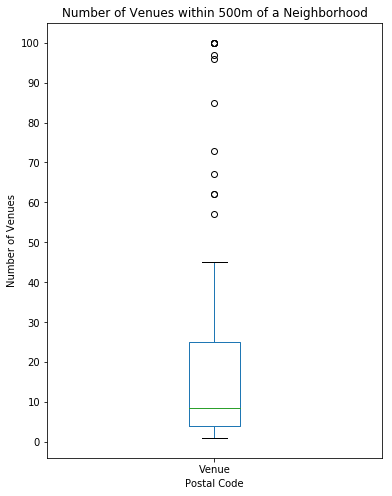

In [22]:
VenuesDF.plot(kind='box', figsize=(6,8))
plt.xlabel('Postal Code')
plt.ylabel('Number of Venues')
plt.yticks(range(0,101,10))
plt.title('Number of Venues within 500m of a Neighborhood')
plt.show()

In [23]:
#Creating one hot DF
T_venues_1HotDF = pd.get_dummies(Tt_venues_DF[['Venue Category']], prefix='', prefix_sep='')
T_venues_1HotDF.insert(loc=0, column='Postal Code', value=Tt_venues_DF['Postal Code'])#USED like an INDEX!
T_venues_1HotDF.shape # shape: (2127, 269)
T_venues_1HotDF.head()

,Postal Code,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M6E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
T_venues_Grouped = T_venues_1HotDF.groupby('Postal Code').mean() # The Postal Code becomes index now
T_venues_Grouped

,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Postal Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

## Dropping the 3 postal codes that don't have any venue

In [25]:
T_venues_Grouped.shape # Getting the shape of Postal Code VS Venue Categories

(98, 262)

# 3. Methodology (Problem Solving Method)
> 
## 3.1 Detailed Steps
> 
### 1) Collect the categories of the venues in their current neighborhood using FourSqare data
> 
### 2) Identify neighborhoods with venues that have similar characteristic to those of their current neighborhood
> 
### 3) Since these neighborhoods can be located across a wide geographical area, incorporate their interested non-venue attribute into their decision making 
> 
#### One obvious metric could be the distance of the neighborhood from their target
> 
#### Will compute the distance between the identified and target neighborhoods using their geolocations
> 

> 
### 4) Dispaly the similar neighborhood data on an interactive geomap with popup capability showing the following to aid the client's selection process
> 
#### a) Neighborhood name
> 
#### b) Distance from the target
> 
#### c) Popular venues in that neighbood
> 
#### d) Target will be red in color,  while their current neighborhood will be in green
> 
### 5) Output the client's choice/selection
> 
#### a) Chosen neighborhood 
> 
#### b) Its comparison with their current neighborhood 

## 3.2 Exploratory Data Analysis
> 
### The number of venues is varying dramatically from neighborhood to neighborhood 

In [26]:
# Examining the data from DF description within 1000m search distance
VenuesDF = Tt_venues_DF.groupby('Postal Code').count()
VenuesDF = VenuesDF['Venue']
VenuesDF.describe()

count     98.000000
mean      21.744898
std       27.774612
min        1.000000
25%        4.000000
50%        8.500000
75%       25.000000
max      100.000000
Name: Venue, dtype: float64

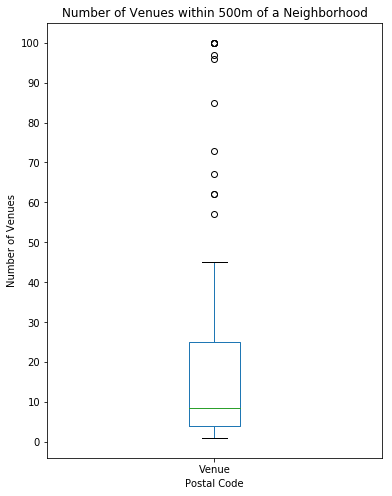

In [27]:
# Examining the Box Plot
VenuesDF.plot(kind='box', figsize=(6,8))
plt.xlabel('Postal Code')
plt.ylabel('Number of Venues')
plt.yticks(range(0,101,10))
plt.title('Number of Venues within 500m of a Neighborhood')
plt.show()

In [28]:
T_venues_Grouped.reset_index(inplace=True) # To get the default index by returning the index to column
T_venues_Grouped.head()

,Postal Code,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    common_venues = []
    for i, v in enumerate(row_categories_sorted[0:num_top_venues]): # Slicing can't be passed as a return argument
        if v != 0.0:
            common_venues.append(row_categories_sorted.index.values[i])
        else:
            common_venues.append('None')
    return common_venues
#    return row_categories_sorted.index.values[0:num_top_venues]

def return_most_common_venues_values(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_sorted_values = []
    for v in row_categories_sorted[0:num_top_venues]: # Slicing can't be passed as a return argument
        row_categories_sorted_values.append(v)
    return row_categories_sorted_values

num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    if ind < 3:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    else:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = T_venues_Grouped['Postal Code']
neighborhoods_venues_sorted_values = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_values['Postal Code'] = T_venues_Grouped['Postal Code']
for ind in np.arange(T_venues_Grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(T_venues_Grouped.iloc[ind, :], num_top_venues)
    neighborhoods_venues_sorted_values.iloc[ind, 1:] = return_most_common_venues_values(T_venues_Grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted.shape
neighborhoods_venues_sorted_values.to_csv("neighborhoods_venues_sorted_values.csv")

In [30]:
# Let's output client current top venues
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Postal Code'].isin([crnt_hood])]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,M1G,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None


In [31]:
# let's define a function to get client's choice of clusters kclusters1=5 or kclusters=8
kclusters1=5
kclusters2=8
def get_kclusters(kclstrs1, kclstrs2):
    complete = False
    while not complete:
        kclstrs=input("Please choose either " + str(kclstrs1) + " or " + str(kclstrs2) + " for clustering of the neighborhoods: ")
        kclstrs = int(kclstrs)
        if (kclstrs == kclstrs1) or (kclstrs == kclstrs2):
            print ("Your chose {} clusters".format(kclstrs))
            complete = True
        else: 
            print ("Your entered {} clusters is neither {} nor {}.".format(kclstrs,kclstrs1,kclstrs2))
            print ("Let's try again.")
    return kclstrs

# Let's get client's choice of clusters
kclusters=get_kclusters(kclusters1, kclusters2) 

Please choose either 5 or 8 for clustering of the neighborhoods: 5
Your chose 5 clusters


In [32]:
# Let's prepare clustering with postal code as index as the venues frequency as columns
# Drop the postal code column it not meant for clustering feature
Tt_grouped_clustering = T_venues_Grouped.drop(labels='Postal Code', axis=1) # the same as T_venues_Grouped.drop('Postal Code', 1)
Tt_grouped_clustering.shape

(98, 262)

Tt_grouped_clustering.head()

# 3.3 Clustering with Machine Learning using KMeans
> 
> Based on the exploratory data analysis there are nearly 300 different categories of venues in the City of Toronto. 
> 
> At this high dimensionality, it’s extremely difficult to cluster effectively.
> 
## Resorted to Machine Learning

In [33]:
# Dimensionality of the samples
Tt_grouped_clustering.shape

(98, 262)

In [34]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tt_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [35]:
neighborhoods_venues_sorted.insert(loc=1, column='Cluster Label', value=kmeans.labels_)
neighborhoods_venues_sorted.head()

,Postal Code,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,2,Fast Food Restaurant,None,None,None,None
1,M1C,0,Bar,None,None,None,None
2,M1E,0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location
3,M1G,0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None
4,M1H,0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant


In [36]:
Tt_pc_clustered_venues = pc_lat_lng.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')
Tt_pc_clustered_venues

,Postal Code,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,43.806686,-79.194353,2.0,Fast Food Restaurant,None,None,None,None
1,M1C,43.784535,-79.160497,0.0,Bar,None,None,None,None
2,M1E,43.763573,-79.188711,0.0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location
3,M1G,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None
4,M1H,43.773136,-79.239476,0.0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant
5,M1J,43.744734,-79.239476,4.0,Playground,Convenience Store,None,None,None
6,M1K,43.727929,-79.262029,0.0,Department Store,Discount Store,Chinese Restaurant,Hobby Shop,Coffee Shop
7,M1L,43.711112,-79.284577,0.0,Bus Line,Bakery,Intersection,Ice Cream Shop,Park
8,M1M,43.716316,-79.239476,0.0,Motel,Movie Theater,Skating Rink,American Restaurant,None
9,M1N,43.692657,-79.264848,0.0,College Stadium,Café,Skating Rink,General Entertainment,None


In [37]:
#Noticed that that we did not get venues for all postal codes; hence, we need to drop the NaN that got populated in the above DF
Tt_pc_clustered_venues.dropna(inplace=True)
Tt_pc_clustered_venues.shape

(98, 9)

In [38]:
Tt_pc_clustered_venues.head()

,Postal Code,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,43.806686,-79.194353,2.0,Fast Food Restaurant,None,None,None,None
1,M1C,43.784535,-79.160497,0.0,Bar,None,None,None,None
2,M1E,43.763573,-79.188711,0.0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location
3,M1G,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None
4,M1H,43.773136,-79.239476,0.0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant


In [39]:
# Noticed that custer label was changed to float in Tt_pc_clusters_venues during joining
# hence change back to int32
Tt_pc_clustered_venues = Tt_pc_clustered_venues.astype({'Cluster Label':'int32'})

Tt_pc_clustered_venues

,Postal Code,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,43.806686,-79.194353,2,Fast Food Restaurant,None,None,None,None
1,M1C,43.784535,-79.160497,0,Bar,None,None,None,None
2,M1E,43.763573,-79.188711,0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location
3,M1G,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None
4,M1H,43.773136,-79.239476,0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant
5,M1J,43.744734,-79.239476,4,Playground,Convenience Store,None,None,None
6,M1K,43.727929,-79.262029,0,Department Store,Discount Store,Chinese Restaurant,Hobby Shop,Coffee Shop
7,M1L,43.711112,-79.284577,0,Bus Line,Bakery,Intersection,Ice Cream Shop,Park
8,M1M,43.716316,-79.239476,0,Motel,Movie Theater,Skating Rink,American Restaurant,None
9,M1N,43.692657,-79.264848,0,College Stadium,Café,Skating Rink,General Entertainment,None


In [40]:
# Readjusting the index to serial as we dropped some rows
Tt_pc_clustered_venues.insert(loc=0, column='Index', value=range(Tt_pc_clustered_venues.shape[0]))
Tt_pc_clustered_venues.set_index(keys='Index', drop=True,inplace=True)
Tt_pc_clustered_venues

,Postal Code,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Index,,,,,,,,,
0,M1B,43.806686,-79.194353,2,Fast Food Restaurant,None,None,None,None
1,M1C,43.784535,-79.160497,0,Bar,None,None,None,None
2,M1E,43.763573,-79.188711,0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location
3,M1G,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None
4,M1H,43.773136,-79.239476,0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant
5,M1J,43.744734,-79.239476,4,Playground,Convenience Store,None,None,None
6,M1K,43.727929,-79.262029,0,Department Store,Discount Store,Chinese Restaurant,Hobby Shop,Coffee Shop
7,M1L,43.711112,-79.284577,0,Bus Line,Bakery,Intersection,Ice Cream Shop,Park
8,M1M,43.716316,-79.239476,0,Motel,Movie Theater,Skating Rink,American Restaurant,None


In [41]:
trgt_lat = Tt_pc_clustered_venues[Tt_pc_clustered_venues['Postal Code'].isin([trgt_hood])]['Latitude']
trgt_lng = Tt_pc_clustered_venues[Tt_pc_clustered_venues['Postal Code'].isin([trgt_hood])]['Longitude']
for lat, lng in zip(trgt_lat, trgt_lng):
    t_lat = lat
    t_lng = lng

dist_from_trgt = []
for lat, lng in zip(Tt_pc_clustered_venues['Latitude'],Tt_pc_clustered_venues['Longitude']):
#    print("{} {} {} {}".format(t_lat, t_lng, lat, lng))
    dist_from_trgt.append(geodistance(t_lat, t_lng, lat, lng))

Tt_pc_clustered_venues['Distance'] = dist_from_trgt
Tt_pc_clustered_venues.to_csv("Clustred_ven_dist.csv")
Tt_pc_clustered_venues

,Postal Code,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Distance
Index,,,,,,,,,,
0,M1B,43.806686,-79.194353,2,Fast Food Restaurant,None,None,None,None,14.4
1,M1C,43.784535,-79.160497,0,Bar,None,None,None,None,14.5
2,M1E,43.763573,-79.188711,0,Breakfast Spot,Medical Center,Bank,Restaurant,Rental Car Location,12.5
3,M1G,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Indian Restaurant,None,None,11.8
4,M1H,43.773136,-79.239476,0,Bakery,Caribbean Restaurant,Hakka Restaurant,Gas Station,Thai Restaurant,11.1
5,M1J,43.744734,-79.239476,4,Playground,Convenience Store,None,None,None,9.7
6,M1K,43.727929,-79.262029,0,Department Store,Discount Store,Chinese Restaurant,Hobby Shop,Coffee Shop,8.1
7,M1L,43.711112,-79.284577,0,Bus Line,Bakery,Intersection,Ice Cream Shop,Park,6.5
8,M1M,43.716316,-79.239476,0,Motel,Movie Theater,Skating Rink,American Restaurant,None,8.5


In [42]:
# Setting up color schemes
# set color scheme for the clusters
x = np.arange(kclusters) # array([0, 1, 2, 3, 4])
ys = [i + x + (i*x)**2 for i in range(kclusters)] # List of 5 arrays of which are manipulated array([0, 1, 2, 3, 4])
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) # shape of (5,4)
rainbow = [colors.rgb2hex(i) for i in colors_array]  # ['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']

In [43]:
# Let's output client current neighborhood's top venues
crnt_hood_DF = Tt_pc_clustered_venues[Tt_pc_clustered_venues['Postal Code'].isin([crnt_hood])]

for clstr, vn1, vn2, vn3, vn4, vn5, dst in zip(crnt_hood_DF['Cluster Label'], crnt_hood_DF['1st Most Common Venue'], 
        crnt_hood_DF['2nd Most Common Venue'], crnt_hood_DF['3rd Most Common Venue'], crnt_hood_DF['4th Most Common Venue'], 
        crnt_hood_DF['5th Most Common Venue'], crnt_hood_DF['Distance']):
    crnt_hood_clstr = clstr
    crnt_hood_venue1 = vn1
    crnt_hood_venue2 = vn2
    crnt_hood_venue3 = vn3
    crnt_hood_venue4 = vn4
    crnt_hood_venue5 = vn5
    crnt_hood_distance = dst
    vn1=vn2=vn3=vn4=vn5=""
print("Current postal code:", crnt_hood)
print("Current neighborhood cluster ID:", crnt_hood_clstr)
print("Current neighborhood 1st venue:", crnt_hood_venue1)
print("Current neighborhood 2nd venue:", crnt_hood_venue2)
print("Current neighborhood 3rd venue:", crnt_hood_venue3)
print("Current neighborhood 4th venue:", crnt_hood_venue4)
print("Current neighborhood 5th venue:", crnt_hood_venue5)
print("Current neighborhood distance from {} postal code: {} miles".format(trgt_hood, crnt_hood_distance))

Current postal code: M1G
Current neighborhood cluster ID: 0
Current neighborhood 1st venue: Coffee Shop
Current neighborhood 2nd venue: Korean Restaurant
Current neighborhood 3rd venue: Indian Restaurant
Current neighborhood 4th venue: None
Current neighborhood 5th venue: None
Current neighborhood distance from M5L postal code: 11.8 miles


In [44]:
# Lets prepare a map with similar neighborhoods as that of the clients neighborhood
Tt_clusters_maps = folium.Map(location=[location.latitude, location.longitude], zoom_start = 10)
for pc, clstr, lat, lng, fst, snd, trd, frt, fft, dist in zip(Tt_pc_clustered_venues['Postal Code'], 
    Tt_pc_clustered_venues['Cluster Label'], Tt_pc_clustered_venues['Latitude'], Tt_pc_clustered_venues['Longitude'], 
    Tt_pc_clustered_venues['1st Most Common Venue'], Tt_pc_clustered_venues['2nd Most Common Venue'], 
    Tt_pc_clustered_venues['3rd Most Common Venue'], Tt_pc_clustered_venues['4th Most Common Venue'], 
    Tt_pc_clustered_venues['5th Most Common Venue'], Tt_pc_clustered_venues['Distance']):
    if pc.find(crnt_hood) != -1:
        radius = 10
        fill_color= 'green'
    if pc.find(trgt_hood) != -1:
        radius = 10
        fill_color= 'red'
    if (pc.find(crnt_hood) == -1) and (pc.find(trgt_hood) == -1): 
        radius = 5
        fill_color= rainbow[clstr]
    str_lbl = "{} clstr:{} dist:{} {}, {}, {}, {},{}".format(pc,clstr, dist,fst,snd,trd,frt,fft)
    flm_lbl = folium.Popup(str_lbl, parse_html=True)
    if (clstr == crnt_hood_clstr) or (pc.find(trgt_hood) != -1):
        folium.CircleMarker(
            [lat, lng],
            radius = radius,
            popup = flm_lbl,
            color = rainbow[clstr],
            fill=True,
            fill_color= fill_color,
            fill_opacity = 0.7,
            parse_html=False).add_to(Tt_clusters_maps)

In [45]:
# Let's prepare a map with all neighborhoods
Tt_clusters_mapa = folium.Map(location=[location.latitude, location.longitude], zoom_start = 10)
for pc, clstr, lat, lng, fst, snd, trd, frt, fft, dist in zip(Tt_pc_clustered_venues['Postal Code'], 
    Tt_pc_clustered_venues['Cluster Label'], Tt_pc_clustered_venues['Latitude'], Tt_pc_clustered_venues['Longitude'], 
    Tt_pc_clustered_venues['1st Most Common Venue'], Tt_pc_clustered_venues['2nd Most Common Venue'], 
    Tt_pc_clustered_venues['3rd Most Common Venue'], Tt_pc_clustered_venues['4th Most Common Venue'], 
    Tt_pc_clustered_venues['5th Most Common Venue'], Tt_pc_clustered_venues['Distance']):
    if pc.find(crnt_hood) != -1:
        radius = 10
        fill_color= 'green'
    if pc.find(trgt_hood) != -1:
        radius = 10
        fill_color= 'red'
    if (pc.find(crnt_hood) == -1) and (pc.find(trgt_hood) == -1): 
        radius = 5
        fill_color= rainbow[clstr]
    str_lbl = "{} clstr:{} dist:{} {}, {}, {}, {},{}".format(pc,clstr, dist,fst,snd,trd,frt,fft)
    flm_lbl = folium.Popup(str_lbl, parse_html=True)
    folium.CircleMarker(
            [lat, lng],
            radius = radius,
            popup = flm_lbl,
            color = rainbow[clstr],
            fill=True,
            fill_color= fill_color,
            fill_opacity = 0.7,
            parse_html=False).add_to(Tt_clusters_mapa)

In [46]:
# Let's get the choice of the client
choice = input("For display selection, please enter 1 for matching or any other number for all neighborhoods: ")
choice = int(choice)
if choice == 1:
    print("You chose to display nighborhoods similar to your current neighborhood in venues.")
    print("To display the map, please type Tt_clusters_maps")
else:
    print("You chose to display all nighborhoods.")
    print("To display the map, please type Tt_clusters_mapa")

For display selection, please enter 1 for matching or any other number for all neighborhoods: 1
You chose to display nighborhoods similar to your current neighborhood in venues.
To display the map, please type Tt_clusters_maps


# 4. Results
> 
## Aiding the client interactively
> 
### Getting client's choices
> 
### Providing immediate feedback on the choices
>
#### Typos such as incorrect postal codes
> 
#### Similarity and dismialrity to the current neighborhood
> 
#### Selectivley showing the neighborhoods on the map

> 
##### Neighborhoods in the same cluster as the clients 
>

In [47]:
Tt_clusters_maps

In [48]:
# Let's check if the user wants alternate view of the venues
if choice == 1:
    print("[You chose to display nighborhoods similar to your current neighborhood in venues before]")
    new_choice = input("Would like to see all the neigbhborhoods(Y for yes)?")
    new_choice = new_choice.lower()
    if (new_choice.find('y') != -1):
        print("You chose to display all nighborhoods.")
        print("To display the map, please type Tt_clusters_mapa")        
else:
    print("[You chose to display all nighborhoods before]")
    new_choice = input("Would like to see similar to your current neighborhood in venues(Y for yes)?")
    new_choice = new_choice.lower()
    if (new_choice.find('y') != -1):
        print("[You chose to display nighborhoods similar to your current neighborhood in venues]")
        print("To display the map, please type Tt_clusters_maps")

[You chose to display nighborhoods similar to your current neighborhood in venues before]
Would like to see all the neigbhborhoods(Y for yes)?y
You chose to display all nighborhoods.
To display the map, please type Tt_clusters_mapa


> 
##### All neighborhoods in case the client wants to explore beyond his cluster
> 

In [49]:
Tt_clusters_mapa

In [50]:
%%capture selectionClosure

complete = False
while not complete:
    selection = False
    print("Current postal code:", crnt_hood)
    print("Current neighborhood cluster ID:", crnt_hood_clstr)
    print("Current neighborhood 1st venue:", crnt_hood_venue1)
    print("Current neighborhood 2nd venue:", crnt_hood_venue2)
    print("Current neighborhood 3rd venue:", crnt_hood_venue3)
    print("Current neighborhood 4th venue:", crnt_hood_venue4)
    print("Current neighborhood 5th venue:", crnt_hood_venue5)
    print("Current neighborhood distance from {} postal code: {} miles".format(trgt_hood, crnt_hood_distance))    
    print("")
    print("Hope you reviewed all the neighborhoods of your choice.")
    print("Let's gather the details of your your choice.")
    while not selection:
        # Let's get client's selection
        sel_hood=get_postal_code("selection") # getting selection postal code
        # Let's output client current neighborhood's top venues
        sel_hood_DF = Tt_pc_clustered_venues[Tt_pc_clustered_venues['Postal Code'].isin([sel_hood])]
        for clstr, vn1, vn2, vn3, vn4, vn5, dst in zip(sel_hood_DF['Cluster Label'], sel_hood_DF['1st Most Common Venue'], 
            sel_hood_DF['2nd Most Common Venue'], sel_hood_DF['3rd Most Common Venue'], sel_hood_DF['4th Most Common Venue'], 
            sel_hood_DF['5th Most Common Venue'], sel_hood_DF['Distance']):
            sel_hood_clstr = clstr
            sel_hood_venue1 = vn1
            sel_hood_venue2 = vn2
            sel_hood_venue3 = vn3
            sel_hood_venue4 = vn4
            sel_hood_venue5 = vn5
            sel_hood_distance = dst
            vn1=vn2=vn3=vn4=vn5=""
        if (sel_hood_clstr != crnt_hood_clstr):
            print("FYI: Selected cluster {} is not similar to your current cluster {}".format(sel_hood_clstr, crnt_hood_clstr))
            slct = input("Would like to select a different postal code(y for yes)?")
            slct = slct.lower()
            if (slct.find("y") == -1):
                selection = True
        else:
            selection = True
    print("")
    print("Selected postal code:", sel_hood)
    print("Selected neighborhood cluster ID:", sel_hood_clstr)
    print("Selected neighborhood 1st venue:", sel_hood_venue1)
    print("Selected neighborhood 2nd venue:", sel_hood_venue2)
    print("Selected neighborhood 3rd venue:", sel_hood_venue3)
    print("Selected neighborhood 4th venue:", sel_hood_venue4)
    print("Selected neighborhood 5th venue:", sel_hood_venue5)
    print("Selected neighborhood distance from {} postal code: {} miles".format(trgt_hood, sel_hood_distance))

    crnt_choice = input("Are you OK with your selection (y for yes)?")
    crnt_choice = crnt_choice.lower()
    if crnt_choice.find('y') != -1:
        complete = True
    else: 
        complete = False

Your selection postal code with 3 chars starting with M, a digit, and a char: m4x
Are you OK with your selection (y for yes)?y


### Providing feedback on the final results

In [51]:
# Printing the interactions capture of the selection closure
for line in re.split(r"\n", selectionClosure.stdout):
    print(line)

Current postal code: M1G
Current neighborhood cluster ID: 0
Current neighborhood 1st venue: Coffee Shop
Current neighborhood 2nd venue: Korean Restaurant
Current neighborhood 3rd venue: Indian Restaurant
Current neighborhood 4th venue: None
Current neighborhood 5th venue: None
Current neighborhood distance from M5L postal code: 11.8 miles

Hope you reviewed all the neighborhoods of your choice.
Let's gather the details of your your choice.
Your entered selection postal code: M4X

Selected postal code: M4X
Selected neighborhood cluster ID: 0
Selected neighborhood 1st venue: Coffee Shop
Selected neighborhood 2nd venue: Bakery
Selected neighborhood 3rd venue: Pizza Place
Selected neighborhood 4th venue: Pub
Selected neighborhood 5th venue: Restaurant
Selected neighborhood distance from M5L postal code: 1.5 miles



In [52]:
Tt_venues_DF.to_csv('venues_dist.csv')

In [53]:
Venue_dist_DF = Tt_venues_DF[['Venue Category','Venue','Venue Distance']] # Get in one shot, not column by column
Crnt_ven_dist_DF = Venue_dist_DF[Tt_venues_DF['Postal Code'].isin([crnt_hood])]
Crnt_ven_dist_DF.index = range(Crnt_ven_dist_DF.shape[0])
Crnt_ven_dist_DF

,Venue Category,Venue,Venue Distance
0,Coffee Shop,Starbucks,0.222
1,Coffee Shop,Tim Hortons,0.308
2,Korean Restaurant,Korean Grill House,0.121
3,Indian Restaurant,Al-Hamd Biryani & Pizza,0.270


In [54]:
Sel_ven_dist_DF = Venue_dist_DF[Tt_venues_DF['Postal Code'].isin([sel_hood])]
Sel_ven_dist_DF.index = range(Sel_ven_dist_DF.shape[0])
Sel_ven_dist_DF

,Venue Category,Venue,Venue Distance
0,Diner,Cranberries,0.087
1,Japanese Restaurant,Kingyo Toronto,0.148
2,Italian Restaurant,F'Amelia,0.056
3,Restaurant,Murgatroid,0.091
4,Café,Merryberry Cafe + Bistro,0.108
5,Café,Cabbagetown Brew,0.108
6,Indian Restaurant,Butter Chicken Factory,0.098
7,Bakery,Absolute Bakery & Café,0.087
8,Jewelry Store,Fair Trade Jewellery Co.,0.184
9,General Entertainment,Toronto Dance Theatre,0.123


# 5. Discussion
> 
## 5.1 Observations
> 
### Clustering was skewed in terms of the number of neighborhoods 
> 
#### some neighborhoods with few venues, while others with a lot of venues.
> 
#### Primarily due to the neighborhoods themselves are skewed alot in terms of venues
> 
### The chosen neighborhood met all the clients current venue needs
> 
#### All good but would the client be able to afford the chosen target?

## 5.2 Recommendation
> 
### Recommend an affordability or a cost of living factor to give another insightful metric of a neighborhood
> 
##### May be something along the following lines:
> 
##### The average/median house price
> 
##### The average/median rental details

# 6. Conclusion
> 
## 6.1 Summary
> 
### Aided the client interactively to choose for the relocation
> 
#### Closer to the target neighborhood
>
#### Meeting all the venues of the current neighborhood
> 
## 6.2 Future work
>
### Extending the service to cover
>
#### Any neighborhood in the world
> 
#### To incoporate some affordability or cost of living factors of neighborhoods
